# Introduction

In this project, I am aiming to predict the sale prices of houses using the Ames Housing Dataset. This dataset contains detailed information about 1000 house sales, including various features such as the size of the house, the number of rooms, the quality of materials used, and more. 

##### Objective
The primary objective of this project is to develop a model that minimizes the Root Mean Squared Error (RMSE) between the predicted and actual sale prices. I am following a structured approach that includes data preprocessing, model selection, hyperparameter tuning, and evaluation. The final model will be used to predict the sale prices on a separate test dataset, and the results will be submitted to a leaderboard for evaluation.

##### Dataset Overview
The project involves two main datasets:

Housing_Data_Train.csv: This file contains the training data, including the sale prices of the houses. We will use this dataset to train and validate our models. --- 1000 rows
Housing_Data_Test.csv: This file contains the test data without the sale prices. We will use our final model to predict the sale prices for this dataset and submit the predictions to the leaderboard. --- 446 rows

##### Project Structure
This notebook is organized into several sections:

- Data Pre-Processing
- Modelling and Model Tuning
- Demonstration of Overfitting vs Underfitting
- Final Linear regression model

 
    

# Preliminaries
## Import and Configuration 

In [1]:
#!pip install -U scikit-learn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import numpy as np
import os
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import KBinsDiscretizer
import statsmodels.api as sm
from itertools import chain, combinations

# Data Preprocessing

Before proceeding with any modifications or training, it is essential to preprocess the data to ensure it is in a suitable format for analysis. This preprocessing step will involve

* **Load:** Load the data from CSV files
* **Clean:** Clean the data to fix any errors or inconsistencies
* **Impute:** Impute any missing values
* **Encode:** Encode the statistical data type (numeric, categorical)


## Load

In [2]:
# get the current directory:
os.getcwd()
train_data=pd.read_csv("C:\\Users\\ASUS\\Documents\\Masters - Guelph\\Fall 2024\\6100\\assignment 1\\Project1_data_files\\Project1_data_files\\Housing_Data_Train.csv")

# Train data:
#display(train_data.head())
#print('Train data contains {} rows and {} features'.format(train_data.shape[0], train_data.shape[1]))


test_data=pd.read_csv("C:\\Users\\ASUS\\Documents\\Masters - Guelph\\Fall 2024\\6100\\assignment 1\\Project1_data_files\\Project1_data_files\\Housing_Data_Test.csv")

# Test data:
#display(test_data.head())
#print('test_data contains {} rows and {} features'.format(test_data.shape[0], test_data.shape[1]))



##### merging the training and test dataframes, to pre-process both of the dataframes together

In [3]:

all_data = pd.concat([train_data, test_data])
#all_data.tail(10)

##### Exploring the descriptive statistics of the variables

In [4]:
all_data.describe(include='all')
all_data.columns.values

array(['Unnamed: 0', 'Id', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual

##### dropping unnecessary fields like unnamed: 0 and Id

In [5]:
data=all_data.drop(['Unnamed: 0', 'Id'],axis=1)

## Clean
 
In this step, missing values in non-numeric categorical features are replaced with 'None', while numeric features related to square footage, garage, and basement are imputed with zero. For 'LotFrontage', missing values are filled using the neighborhood median. Categorical features like 'MSZoning' and 'KitchenQual' are imputed with the most frequent value (mode).

In [6]:
missing_values=data.isnull().sum()
missing_columns=missing_values[missing_values>0]
#print(missing_columns)

In [7]:

missing_values_percentage = data.isnull().sum() / len(data) * 100

# Filter columns with more than 90% missing values
columns_to_drop1 = missing_values_percentage[missing_values_percentage > 90].index

# Print the columns to drop
print("Columns with more than 95% missing values:")
print(columns_to_drop1)

Columns with more than 95% missing values:
Index(['Alley', 'PoolQC', 'MiscFeature'], dtype='object')


PoolQC (1440 missing values out of 1446 total rows), Alley (1356 missing values out of 1446 total rows) and MiscFeature (1392 missing values out of 1446 total rows) have a very high percentage of missing values. Hence dropping these at this stage as, drop 1.

In [8]:
drop1=columns_to_drop1  ## as these field have missing values for almost evry observation
data=data.drop(columns_to_drop1,axis=1)

## Impute

- #### Replace Null Values with 'None' for Non-Numeric Features
These features are categorical and represent qualitative attributes (e.g., basement finish type, garage quality).
Replacing NaN with 'None' indicates that the feature is absent for that particular house.
- #### Imputing LotFrontage with Median by Neighborhood
LotFrontage represents the linear feet of street connected to the property.
Imputing with the median value of the properties like neighborhood, house style assumes that properties within the same neighborhood have similar lot frontage.
- #### Zero Imputing for Numeric Features
 These features are numeric and represent quantitative attributes (e.g., basement finished square feet, garage area).
 KNN imputation, which fills missing values based on the similarity to other houses.
Replacing NaN with 0 assumes that the absence of these features means they have zero value (e.g., no basement, no garage)
- #### Zero Imputing with Mode for Categorical Features
These features are categorical and represent qualitative attributes (e.g., zoning classification, electrical system).
Replacing NaN with the mode (most frequent value) assumes that the most common value is a reasonable default


In [9]:
# Replace Na null values for this features with None:
non_numeric = [ 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Fence','FireplaceQu', 'GarageFinish','GarageQual', 'GarageCond','GarageType','MasVnrType']

for col in non_numeric:
    data[col] = data[col].fillna('None')


# LotFrontage: seems like 
#data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
#    lambda x: x.fillna(x.median()))
data["LotFrontage"] = data.groupby(["Neighborhood", "HouseStyle"])["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
overall_median = data["LotFrontage"].median()
data["LotFrontage"].fillna(overall_median, inplace=True)


# Zero imputing missing values:
numeric_1 = [ 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath','GarageArea', 'GarageYrBlt','GarageCars','MasVnrArea','TotalBsmtSF']

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
data[numeric_1] = imputer.fit_transform(data[numeric_1])


#for col in numeric_1:
#    data[col] = data[col].fillna(0)


# Zero imputing with mode:
numeric_2 = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 
                      'SaleType']
for col in numeric_2:
    data[col] = data[col].fillna(data[col].mode()[0])



C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: M

- This code converts categorical variables into dummy/indicator variables and drops the first category to avoid multicollinearity (perfect collinearity) among the dummy variables.

- For each categorical column with k categories, k-1 dummy variables are created

## Encode

In [10]:
data_with_dummies = pd.get_dummies(data, drop_first=True)

##### spliting the all_data dataframe again to the test and training dataframes after the pre-processing

In [11]:


train_index = range(1000)  # First 1000 records
test_index = range(1000, 1446)

train_data, test_data = train_test_split(data_with_dummies, train_size=1000, test_size=446, shuffle=False)

##### spliting the 'data' dataframe to compare encoded dataframes with the not encoded adtaframe after the pre-processing 

In [12]:


train_index = range(1000)  # First 1000 records
test_index = range(1000, 1446)

train_data_no_encode, test_data_no_encode = train_test_split(data, train_size=1000, test_size=446, shuffle=False)

### Metric Function
### Target Variable : SalePrice

Visualizeing the distribution of house sale prices to identify skewness and outliers.

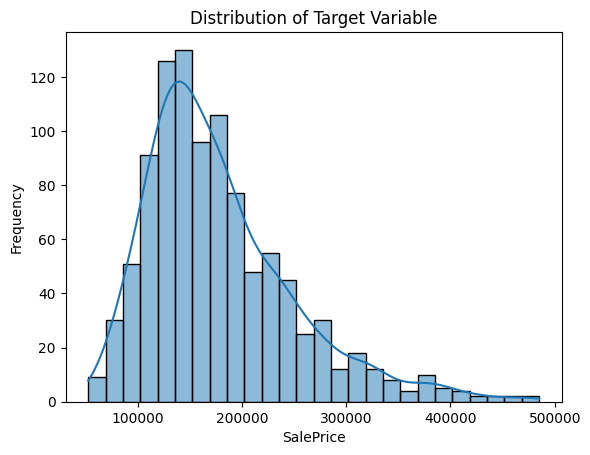

In [13]:
# Distribution of the target variable
sns.histplot(train_data.SalePrice, kde=True) 
plt.title('Distribution of Target Variable')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

The target variable, SalePrice, is heavily skewed, meaning it isn't normally distributed

### Data 1 definition

Removeing top 1% of sale prices to mitigate skewness and improve model performance

In [14]:

q=train_data['SalePrice'].quantile(0.99)
train_data_1=train_data[train_data['SalePrice'] < q]


After removing the outliers, verifying the skewness of the distribution

<Axes: xlabel='SalePrice', ylabel='Count'>

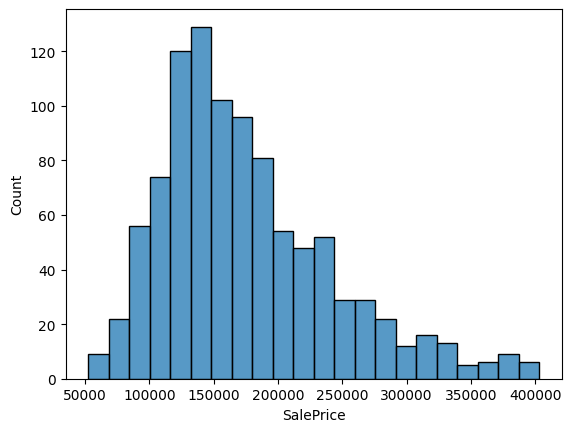

In [15]:
sns.histplot(train_data_1['SalePrice'])

#### Visual Inspection

plotting numerical cols to see the relevant features

approach to visually inspect and identify outliers in numerical features for further removal.

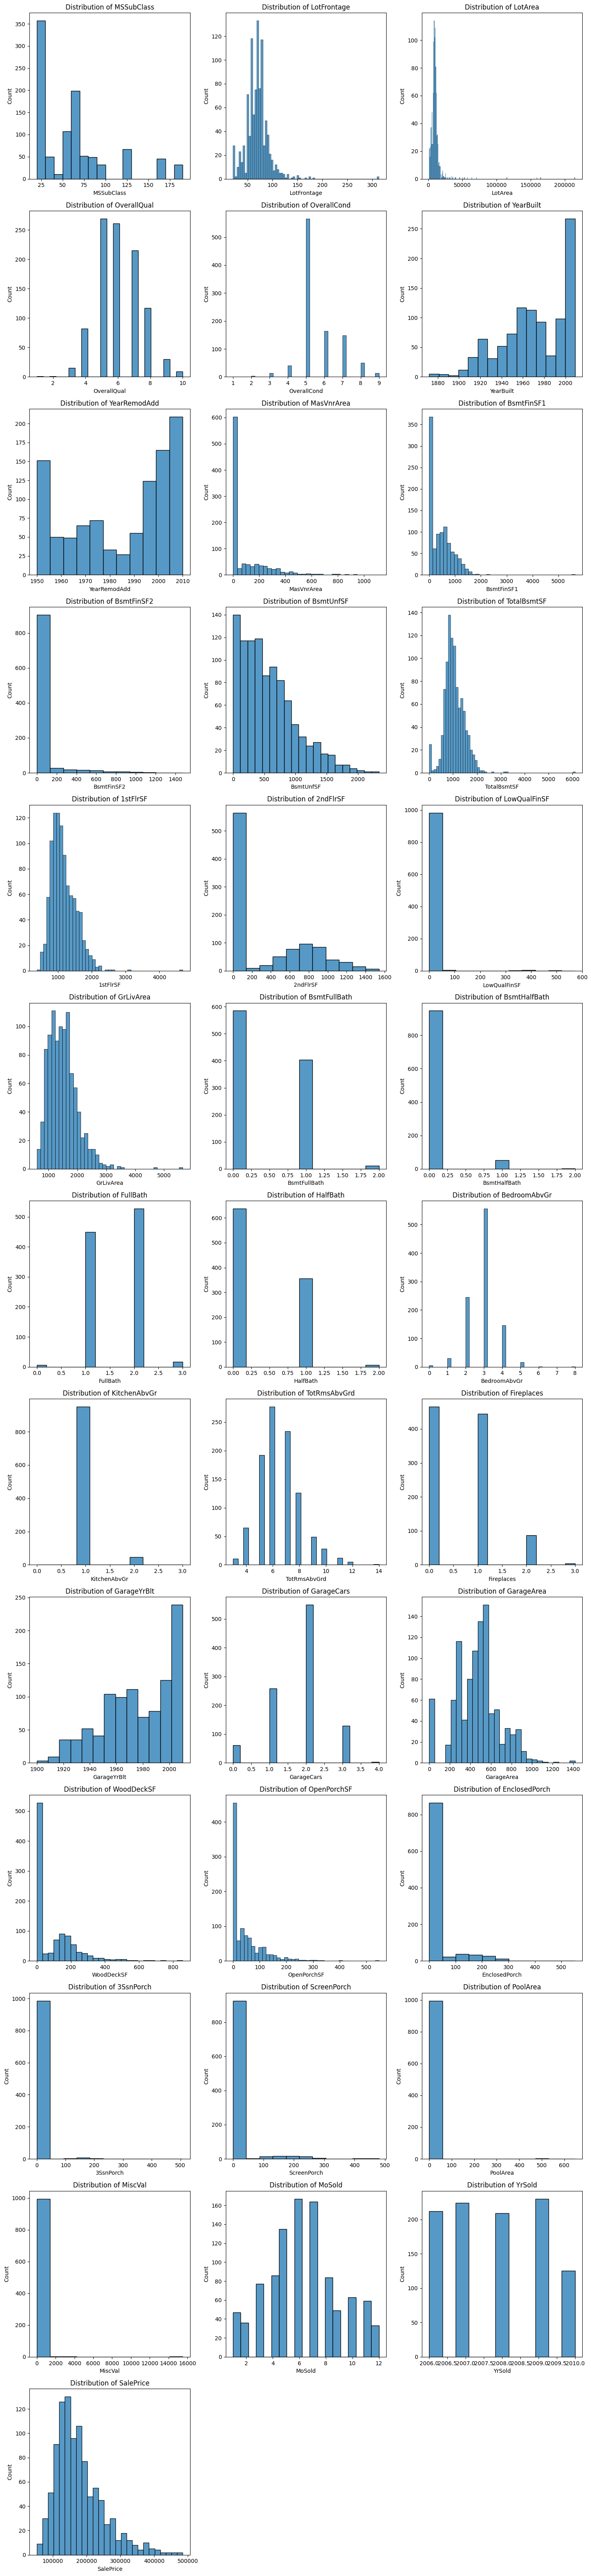

In [16]:
numeric_columns=train_data_no_encode.select_dtypes(include=['int64','float64'])
num_cols = len(numeric_columns.columns)
num_rows = (num_cols + 2) // 3  # Adjust the number of columns as needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

# Plot histograms in the subplots
for i, column in enumerate(numeric_columns.columns):
    sns.histplot(train_data_no_encode[column], ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

# Hide any unused subplots
for j in range(num_cols, num_rows * 3):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Plotting selected numerical cols to see outliers 

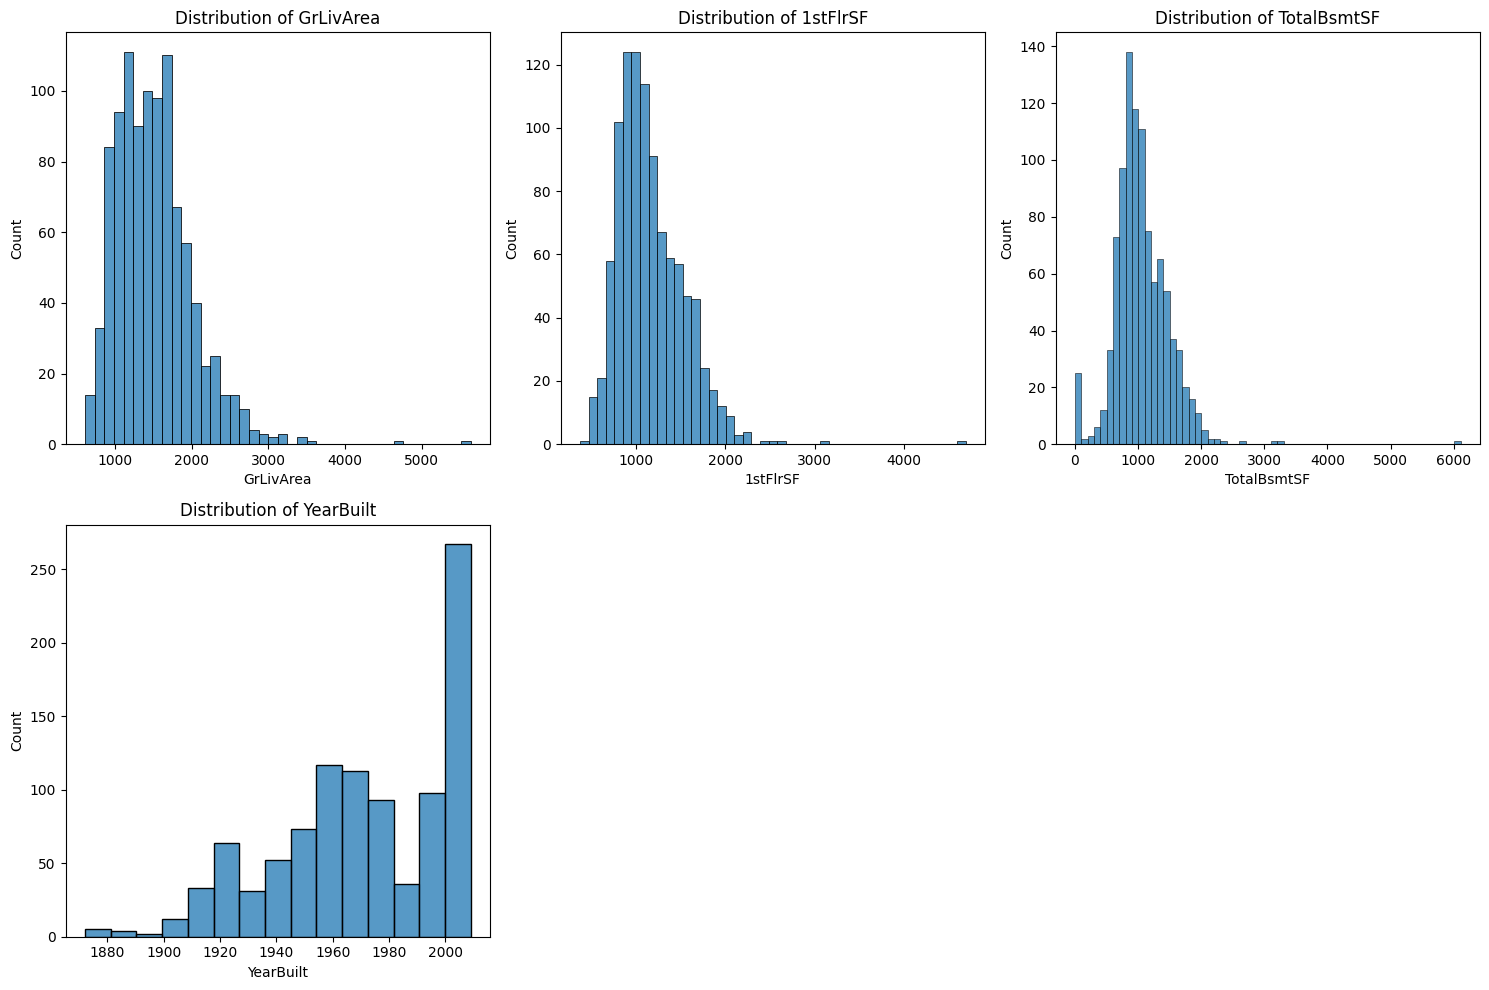

In [17]:
numeric_columns=['GrLivArea', '1stFlrSF','TotalBsmtSF', 'YearBuilt']
num_cols = len(numeric_columns)
num_rows = (num_cols + 2) // 3  # Adjust the number of columns as needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

# Plot histograms in the subplots
for i, column in enumerate(numeric_columns):
    sns.histplot(train_data_no_encode[column], ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

# Hide any unused subplots
for j in range(num_cols, num_rows * 3):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

From the above plots , it can be seen, that for the fields ['GrLivArea', '1stFlrSF','TotalBsmtSF', 'YearBuilt'] , there are some outliers which is disturbing their distribution.

In [18]:
train_data_2=train_data_1[train_data_1['TotalBsmtSF'] < 3000]


In [19]:
train_data_3=train_data_2[train_data_2['1stFlrSF']< 3000]


In [20]:
train_data_4=train_data_3[train_data_3['GrLivArea']< 4000]


In [21]:
train_data_5=train_data_4[train_data_4['YearBuilt']> 1900]

### plotting the graphs after removing outliers

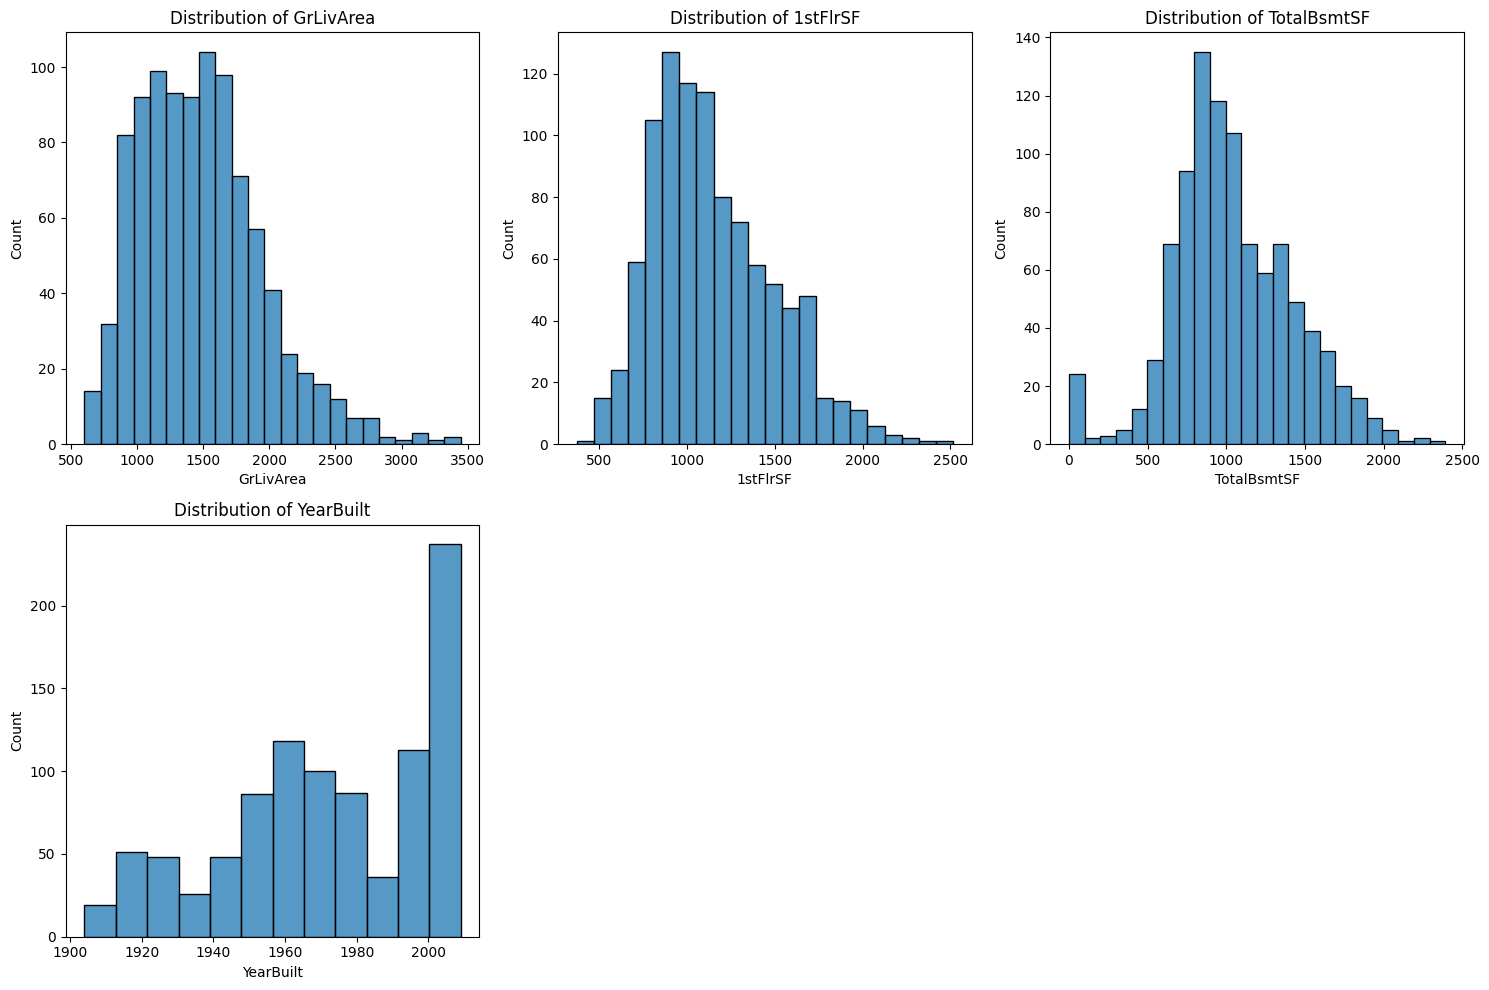

In [22]:
numeric_columns=['GrLivArea', '1stFlrSF','TotalBsmtSF', 'YearBuilt']
num_cols = len(numeric_columns)
num_rows = (num_cols + 2) // 3  # Adjust the number of columns as needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

# Plot histograms in the subplots
for i, column in enumerate(numeric_columns):
    sns.histplot(train_data_5[column], ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

# Hide any unused subplots
for j in range(num_cols, num_rows * 3):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Correlation

Examining the correlation between numerical features and the target variable to understand their relationship. This helps me identify which features have a strong impact on the target. A strong positive correlation means that as the feature increases, the target value also tends to rise, while a negative correlation indicates that as the feature increases, the target value decreases. This analysis will guide me in selecting important features for the model.

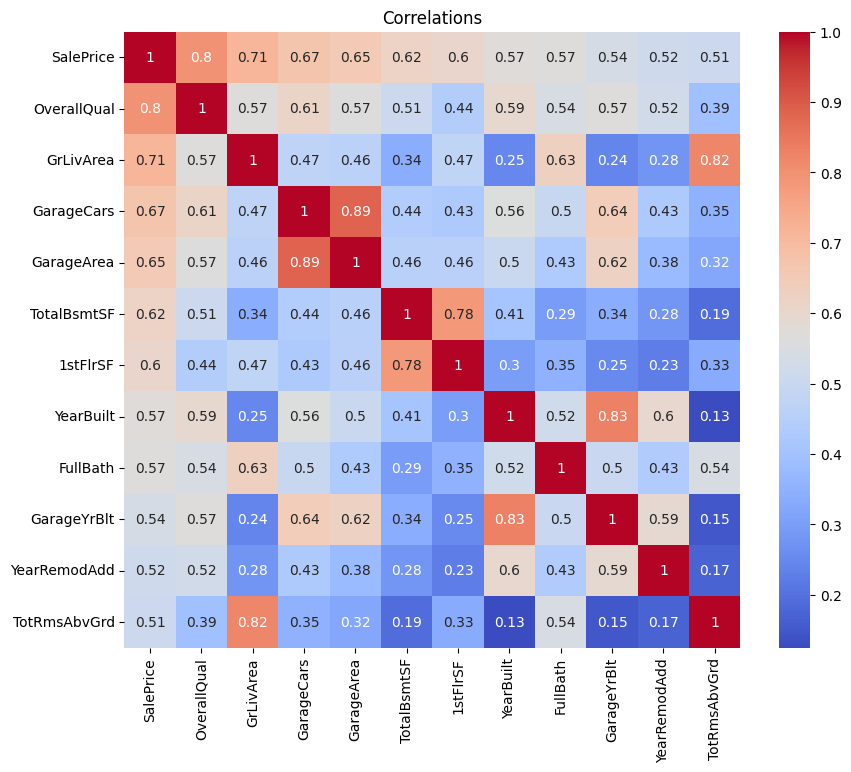

In [23]:
train_data_num=train_data_5.select_dtypes(include=['float64','int64'])


# Calculating correlations :
train_corr = train_data_num.select_dtypes(include=['int64','float64'])
corr = train_corr.corr()

# Sorting correlations with SalePrice:
corr_sorted = corr['SalePrice'].abs().sort_values(ascending=False)
corr_high = corr_sorted[corr_sorted>0.5].index

# Subsetting correlations:
corr = corr.loc[corr_high, corr_high]


# Visualizeing:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Correlations')
plt.show()



OverallQual and GarageCars have the highest correlation with SalePrice:

* **GrLivArea:** Above grade (ground) living area square feet.
* **GarageArea:** Size of garage 

The other 5 six variables with a correlation higher than 0.5 with SalePrice are:   --1stFlrSF: First Floor square feet  TotalBsmtSF: Total square feet of basement area  -YearBuilt: Original construction date -FullBath: Full bathrooms above grade -YearRemodAdd: Remodel date (same as construction date if no remodeling or additions).

GarageCars and GarageArea have a correlation of 0.67,0.65 meaning they move together strongly. It is multicollinearity. Why Multicollinearity is an Issue? When multicollinearity is present:

* **Redundancy:** Both variables are conveying essentially the same information. Including both doesn't add value and might lead to confusing results.
* **Unstable Coefficients:** The regression model may struggle to determine which variable (GarageCars or GarageArea) is more important, leading to unstable coefficient estimates. This means small changes in the data could cause large swings in the coefficients, making the model less reliable.



In [24]:
from sklearn.feature_selection import VarianceThreshold


X = train_data_num.drop(columns=['SalePrice'])  # Drop the target variable

# Initialize VarianceThreshold with a threshold value
# A common threshold is 0.1, but you can adjust it based on your dataset
selector = VarianceThreshold(threshold=0.1)

# Fit and transform the data
X_new = selector.fit_transform(X)

# Get the names of the selected features
selected_features = X.columns[selector.get_support()]

# Create a new DataFrame with only the selected features
train_data_num_selected = train_data_num[selected_features.union(['SalePrice'])]

# Print the selected features
print("Selected Features:")
print(selected_features)

# Print the shape of the new DataFrame
print("Shape of the new DataFrame:", train_data_num_selected.shape)


Selected Features:
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')
Shape of the new DataFrame: (969, 35)


GarageCars and GarageArea are corelated
GrLivArea and TotRmsAbvGrd are corelated
TotalBsmtSF and 1stFlrSF are corelated

dropping TotRmsAbvGrd, GarageArea , 1stFlrSF

In [25]:
#train_data_6=train_data_5.drop(['TotRmsAbvGrd', 'GarageArea' , '1stFlrSF'],axis=1)
train_data_6=train_data_5

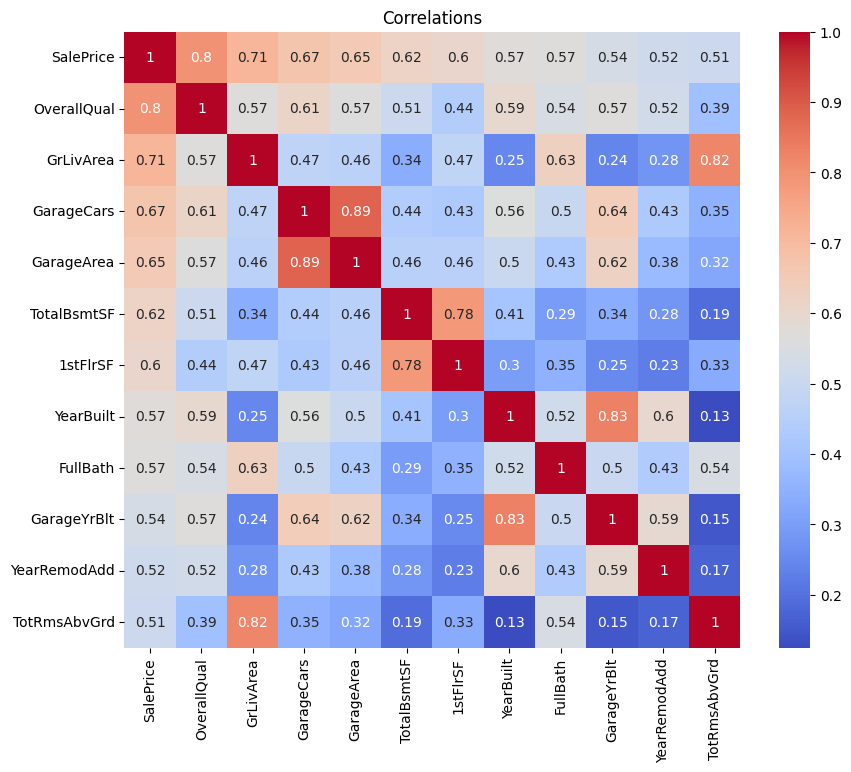

In [26]:
train_data_num=train_data_6.select_dtypes(include=['float64','int64'])


# Calculating correlations :
train_corr = train_data_num.select_dtypes(include=['int64','float64'])
corr = train_corr.corr()

# Sorting correlations with SalePrice:
corr_sorted = corr['SalePrice'].abs().sort_values(ascending=False)
corr_high = corr_sorted[corr_sorted>0.5].index

# Subsetting correlations:
corr = corr.loc[corr_high, corr_high]


# Visualizeing:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Correlations')
plt.show()

### Multicollinearity

In [27]:
df=train_data_6
correlated_features = []
for i in range(len(df.columns)):
  for j in range(i+1, len(df.columns)):
    first_feature = df.columns[i]
    second_feature = df.columns[j]
    pairwise_correlation = df[first_feature].corr(df[second_feature])
    # if the correlation is above 0.9, then add the pair to the correlated_features
    if abs(pairwise_correlation) > 0.9 :
      correlated_features.append((first_feature, second_feature))
    drop_features = set()
    # from the pairwise highly correlated features, drop one of the features that has lower
    # correlation with target 'SalePrice' variable
    for first_feature, second_feature in correlated_features :
      feature1_corr = df[first_feature].corr(df['SalePrice'])
      feature2_corr = df[second_feature].corr(df['SalePrice'])
      if(abs(feature1_corr) < abs(feature1_corr)):
        drop_features.add(first_feature)
      else:
        drop_features.add(second_feature)


#View features
correlated_features

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[('RoofStyle_Gable', 'RoofStyle_Hip'),
 ('Exterior1st_CBlock', 'Exterior2nd_CBlock'),
 ('Exterior1st_CemntBd', 'Exterior2nd_CmentBd'),
 ('Exterior1st_MetalSd', 'Exterior2nd_MetalSd'),
 ('Exterior1st_VinylSd', 'Exterior2nd_VinylSd'),
 ('ExterQual_Gd', 'ExterQual_TA'),
 ('ExterCond_Gd', 'ExterCond_TA'),
 ('BsmtQual_None', 'BsmtCond_None'),
 ('BsmtQual_None', 'BsmtExposure_None'),
 ('BsmtQual_None', 'BsmtFinType1_None'),
 ('BsmtQual_None', 'BsmtFinType2_None'),
 ('BsmtCond_None', 'BsmtExposure_None'),
 ('BsmtCond_None', 'BsmtFinType1_None'),
 ('BsmtCond_None', 'BsmtFinType2_None'),
 ('BsmtExposure_None', 'BsmtFinType1_None'),
 ('BsmtExposure_None', 'BsmtFinType2_None'),
 ('BsmtFinType1_None', 'BsmtFinType2_None'),
 ('GarageType_None', 'GarageFinish_None'),
 ('GarageType_None', 'GarageQual_None'),
 ('GarageType_None', 'GarageCond_None'),
 ('GarageFinish_None', 'GarageQual_None'),
 ('GarageFinish_None', 'GarageCond_None'),
 ('GarageQual_None', 'GarageCond_None'),
 ('SaleType_New', 'SaleCond

Removing the features which are having the negative co-relation with the target variable

In [28]:
df1 = train_data_num.corr()['SalePrice'] < 0 
series_dict = df1.to_dict()

# Filter the dictionary to get only columns with True values
columns_to_drop2 = [key for key, value in series_dict.items() if value]

# Print the list of column names with True values
print(columns_to_drop2)

['MSSubClass', 'OverallCond', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', 'MiscVal', 'YrSold']


In [29]:

#train_data_7=train_data_6.drop(columns_to_drop2,axis=1)
train_data_7=train_data_6

In [30]:
train_data_7.corr()['SalePrice'].sort_values(ascending = False)

SalePrice          1.000000
OverallQual        0.796236
GrLivArea          0.713294
GarageCars         0.669575
GarageArea         0.652390
                     ...   
Condition2_RRAn         NaN
Condition2_RRNn         NaN
RoofStyle_Shed          NaN
Heating_OthW            NaN
Functional_Sev          NaN
Name: SalePrice, Length: 251, dtype: float64

In [31]:
train_data_7.columns.values

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'LotShape_IR2',
       'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'Utilities_NoSeWa',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev',
       'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSi

In [32]:
df2 = train_data_7.corr()['SalePrice'] < 0 
series_dict = df2.to_dict()

# Filter the dictionary to get only columns with True values
columns_to_drop3 = [key for key, value in series_dict.items() if value]

# Print the list of column names with True values
print(columns_to_drop3)

['MSSubClass', 'OverallCond', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', 'MiscVal', 'YrSold', 'MSZoning_RH', 'MSZoning_RM', 'LotShape_Reg', 'LandContour_Lvl', 'Utilities_NoSeWa', 'LotConfig_Inside', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Condition1_Feedr', 'Condition1_RRAe', 'Condition1_RRNn', 'Condition2_Feedr', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Unf', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofMatl_CompShg', 'RoofMatl_Roll', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stucco', 'Exterior1st_Wd Sdng', 'E

In [33]:

#train_data_8=train_data_7.drop(columns_to_drop3,axis=1)
train_data_8=train_data_7

### Mutual Information

Using both Mutual Information (MI) and correlation to measure relationships between variables. While correlation only captures linear relationships and is easy to interpret (ranging from -1 to 1), MI can detect both linear and non-linear dependencies, making it more versatile. MI works for both categorical and continuous data and can uncover more complex interactions, though it is less straightforward and more computationally intensive than correlation.

In [34]:

X = train_data_8.copy()
y = X.pop('SalePrice')

# Factorize categorical variables
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Discretize the target variable
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
y_discrete = discretizer.fit_transform(y.values.reshape(-1, 1))

# Calculate mutual information scores
mi_scores = mutual_info_classif(X, y_discrete.ravel())
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)




In [35]:
#Features with zero mutual information scores
zero_mi_scores = mi_scores[mi_scores == 0]
zero_mi_fields = zero_mi_scores.index.tolist()
print("Features with zero mutual information scores:", zero_mi_fields)

Features with zero mutual information scores: ['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'LotShape_IR2', 'LandContour_Low', 'Utilities_NoSeWa', 'LotConfig_FR2', 'Neighborhood_Blueste', 'Neighborhood_Edwards', 'Neighborhood_NPkVill', 'Neighborhood_SawyerW', 'Neighborhood_Veenker', 'Condition1_Norm', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'BldgType_TwnhsE', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'RoofStyle_Gambrel', 'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_ImStucc', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_Wd Sdng', 'Exterior2nd_AsphShn', 'Exterior2nd_BrkFace', 'Exterior2nd_HdBoard', 'Exterior2nd_Wd Shng', 'ExterQual_F

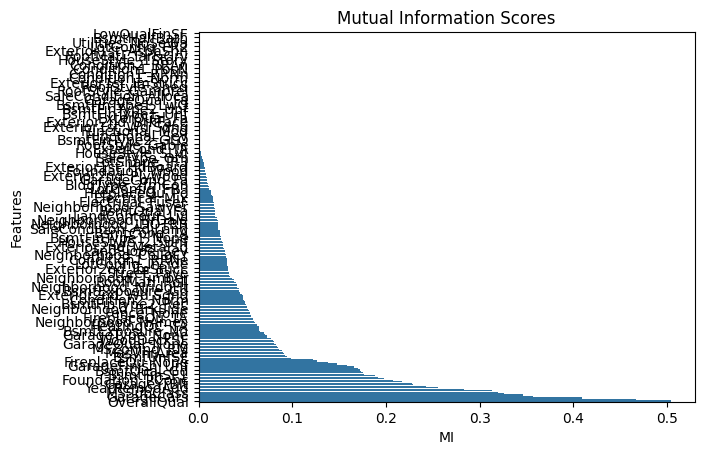

In [36]:

# Function to plot the mi_scores
def plot_mi_scores(scores):
    # Sort the scores
    scores = scores.sort_values(ascending=True)
    sns.barplot(x=scores, y=scores.index)
    tick_locations = range(0, len(scores.index), 3)  # every 3 units
    tick_labels = scores.index[tick_locations]
    plt.yticks(tick_locations, tick_labels)
    plt.xlabel('MI')
    plt.ylabel('Features')
    plt.title('Mutual Information Scores')

# Plot the MI scores
plot_mi_scores(mi_scores)
plt.show()

In [37]:
len(zero_mi_fields)
columns_to_drop4=zero_mi_fields

In [38]:
# Function to drop uninformative features:
drop5=zero_mi_fields
#train_data_9 = train_data_8.drop(columns=columns_to_drop4)
train_data_9 = train_data_8

In [39]:
train_data_9=train_data_9.reset_index(drop=True)

In [40]:
boolean_cols = train_data_9.select_dtypes(include=['bool']).columns

# Convert boolean columns to integers
train_data_9[boolean_cols] = train_data_9[boolean_cols].astype(int)

In [41]:
X = train_data_9.drop('SalePrice', axis = 1)
y = train_data_9['SalePrice']

# Modelling and Model tuning

#### feature selection and model evaluation

Performing feature selection using K-Fold cross-validation, evaluating each subset of features based on the Root Mean Square Error (RMSE)

processSubset: Evaluates a given feature subset using K-Fold cross-validation and Ridge regression within a 4-fold cross-validation framework.

In [42]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from joblib import Parallel, delayed


def processSubset(feature_set, X, y, alpha=1.0): 
    
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    list_rmse_val = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = Ridge(alpha=alpha)  
        model.fit(X_train[list(feature_set)], y_train)  
        
        predictions = model.predict(X_test[list(feature_set)])
        RMSE_val = np.sqrt(np.mean((predictions - y_test) ** 2))
        list_rmse_val.append(RMSE_val)
    
    average_rmse = np.mean(list_rmse_val)
    return {'p': len(feature_set), 'features': feature_set, 'model': model, 'RMSE': average_rmse}
## reference taken from course github

Defining Forward selection function

forward feature selection strategy is implemented here, iteratively adding the most valuable features based on the lowest RMSE achieved. Parallel processing is leveraged to expedite this selection by evaluating multiple feature subsets concurrently.

In [43]:

def forward(predictors, X, y, alpha=1.0, max_predictors=None, n_jobs=-1):  
    
    remaining_predictors = [col for col in X.columns if col not in predictors]
    
    results = Parallel(n_jobs=n_jobs)(delayed(processSubset)(predictors + [feature], X, y, alpha) 
                                      for feature in remaining_predictors)
    
    models = pd.DataFrame(results)
    best_model = models.loc[models['RMSE'].idxmin()]
    
    return best_model

The code scales features using StandardScaler. This ensures that features with different scales do not unduly influence the model. 

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_scaled = scaler.fit_transform(X)  

# Convert the scaled data back to a Pandas DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


The scaled data is then fed into the forward function to identify the best set of features for predicting the target variable.

In [46]:
models = pd.DataFrame(columns=['p', 'RMSE', 'features', 'model'])
predictors = []
number_of_features = len(X.columns)

for i in range(1, number_of_features + 1):
    best_model = forward(predictors, X_scaled, y, alpha=1.0)  # You can adjust alpha here
    models.loc[i] = best_model
    predictors = list(best_model['features'])  # Get features from the best model

models['RMSE'] = models['RMSE'].astype(float)

In [48]:
models['RMSE'].min()


np.float64(18660.053931936192)

In [49]:
min_index = models['RMSE'].idxmin()

# Get the value from 'another_column' corresponding to the minimum value in 'column_name'
corresponding_value = models.loc[min_index, 'features']


In [50]:
len(corresponding_value)

98

##### Checking the row in models with the minimum RMSE to identify the feature set that performed best during forward selection.

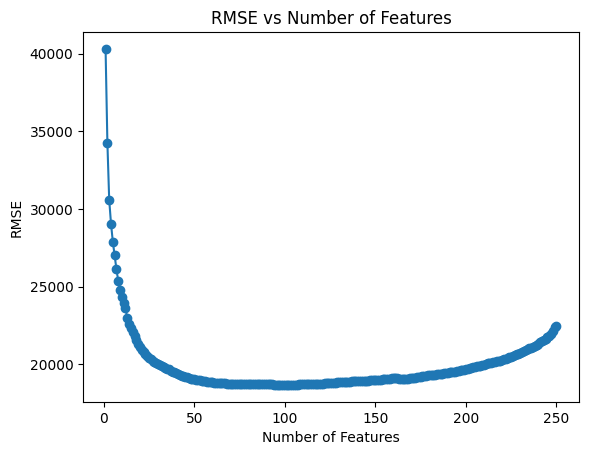

In [51]:
import matplotlib.pyplot as plt

plt.plot(models['p'], models['RMSE'], marker='o')
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.title("RMSE vs Number of Features")
plt.show()


The above plot illustrates the relationship between RMSE and the number of features in the model. Initially, adding features improved the model's accuracy. However, beyond a certain point, the RMSE starts increasing due to overfitting, where the model becomes too complex.

##### Function to train a model on a subset of features using the entire dataset

In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from joblib import Parallel, delayed


def processSubsetWithoutTestData(feature_set, X, y, alpha=1.0):
    model = Ridge(alpha=alpha)  # Use Ridge instead of OLS
    model.fit(X[list(feature_set)], y) 
    RMSE = np.sqrt(np.mean((model.predict(X[list(feature_set)]) - y) ** 2))
    return {'p': len(feature_set), 'features': feature_set, 'model': model, 'RMSE': RMSE}


def forward_method_for_entire_training_data(predictors, X, y, alpha=1.0):
    remaining_features = [col for col in X.columns if col not in predictors]
    results = []
    for col in remaining_features:
        model_result = processSubsetWithoutTestData(predictors + [col], X, y, alpha=alpha)
        results.append(model_result)
    models = pd.DataFrame(results)
    best_model = models.loc[models['RMSE'].idxmin()]
    return best_model

# DataFrame to store results of forward selection
models_with_noTestSet = pd.DataFrame(columns=['RMSE', 'model', 'features'], dtype=object)

predictor_features = []
number_of_features = len(X.columns)

# Perform forward selection on the full training set
for i in range(1, number_of_features + 1):
    best_model = forward_method_for_entire_training_data(predictor_features, X_scaled, y, alpha=1.0)  # Pass alpha here
    models_with_noTestSet.loc[i] = best_model
    predictor_features = list(best_model['features'])  # Get features from the best model



##### Plot for RMSE value for entire Train Dataset vs number of predictors

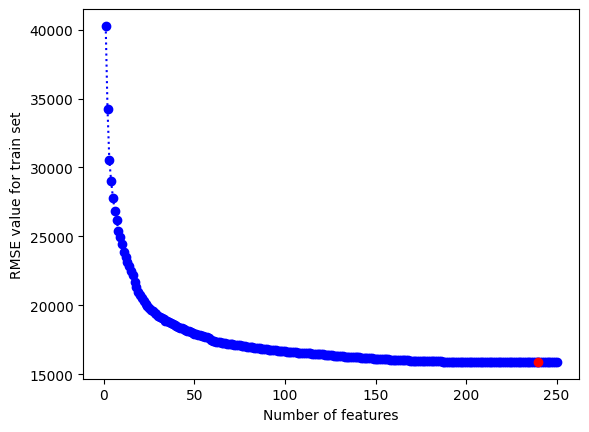

In [53]:

plt.plot(models_with_noTestSet['RMSE'], 'ob', linestyle='dotted')
plt.xlabel('Number of features')
plt.ylabel('RMSE value for train set')
plt.plot(models_with_noTestSet['RMSE'].astype(float).idxmin(),
         models_with_noTestSet['RMSE'].min(), 'or')

plt.show()

In [69]:
models_with_noTestSet['RMSE'].min()

15886.775503449218

The above plot illustrates the relationship between the Root Mean Squared Error (RMSE) and the number of features used in the model on the entire dataset. Initially, adding more features leads to a decrease in RMSE, suggesting improved model performance. The red dot likely marks the point where the model's performance starts to degrade due to overfitting, emphasizing the importance of feature selection and avoiding excessive model complexity.


In [54]:
models_with_noTestSet.head()

,RMSE,model,features
1,40268.081194,Ridge(),[OverallQual]
2,34252.090098,Ridge(),"[OverallQual, GrLivArea]"
3,30542.375788,Ridge(),"[OverallQual, GrLivArea, BsmtFinSF1]"
4,28995.802263,Ridge(),"[OverallQual, GrLivArea, BsmtFinSF1, GarageCars]"
5,27798.412057,Ridge(),"[OverallQual, GrLivArea, BsmtFinSF1, GarageCar..."


# Demonstration of Overfitting vs Underfitting

## Cross-Validated RMSE vs Number of Features

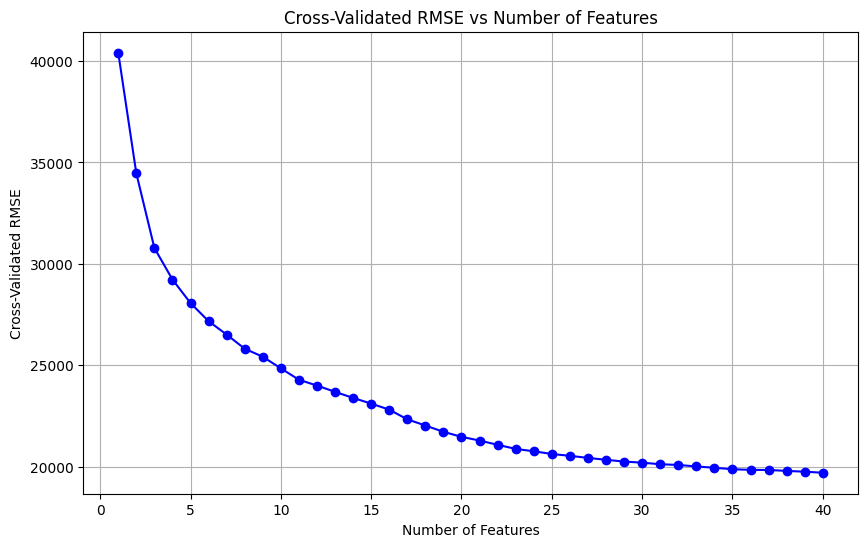

In [55]:
from sklearn.model_selection import cross_val_score


# Define the maximum number of features to test based on your plot's curve
max_features = 40  # Adjust this based on where the RMSE curve flattens

# List to store cross-validated RMSE values
cv_rmse_values = []

for i in range(1, max_features + 1):
    # Select the top i features from your forward selection model
    features = models_with_noTestSet.loc[i]['features']
    X_selected = X[features]
    
    # Initialize the model (LinearRegression used as proxy for statsmodels OLS)
    model = LinearRegression()
    
    # Perform 10-fold cross-validation and calculate RMSE
    cv_rmse = np.sqrt(-cross_val_score(model, X_selected, y, cv=10, scoring='neg_mean_squared_error').mean())
    cv_rmse_values.append(cv_rmse)

# Plotting Cross-Validated RMSE vs Number of Features
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_features + 1), cv_rmse_values, marker='o', color='b')
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated RMSE")
plt.title("Cross-Validated RMSE vs Number of Features")
plt.grid(True)
plt.show()


## Learning curve

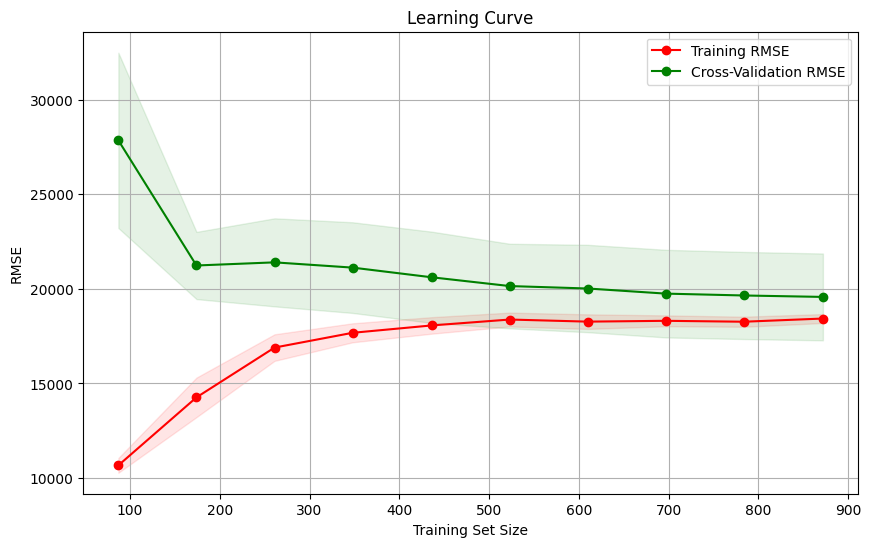

In [56]:
from sklearn.model_selection import learning_curve

# Choose the optimal number of features based on the cross-validated RMSE plot
optimal_features = models_with_noTestSet.loc[cv_rmse_values.index(min(cv_rmse_values)) + 1]['features']
X_optimal = X[optimal_features]

# Initialize the model
model = LinearRegression()

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    model, X_optimal, y, cv=10, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation of RMSE for train and test scores
train_rmse = np.sqrt(-train_scores)
test_rmse = np.sqrt(-test_scores)

train_mean = np.mean(train_rmse, axis=1)
train_std = np.std(train_rmse, axis=1)
test_mean = np.mean(test_rmse, axis=1)
test_std = np.std(test_rmse, axis=1)

# Plot the Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training RMSE")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-Validation RMSE")

# Shaded area for standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()


Training RMSE (Red Line):

The training RMSE starts low and increases slightly as the training set size grows.
The initial low RMSE for smaller training sizes indicates that the model fits the training data very well.

As the training set size increases, the training RMSE rises and stabilizes, suggesting the model becomes less biased towards any small data subset and finds a more general pattern.

Cross-Validation RMSE (Green Line):

The cross-validation RMSE starts high when the training set size is small, which is typical.

As the training set size increases, the cross-validation RMSE decreases and stabilizes, indicating better generalization as the model sees more data.

The fact that the cross-validation RMSE converges to a stable value shows that adding more training data doesn’t significantly reduce the model error at a certain point, suggesting that the model has learned most of the generalizable patterns in the data.

Gap Between Training and Cross-Validation RMSE:

There is a small gap between the training and cross-validation RMSE at higher training sizes, which is a positive sign.
This indicates that the model does not significantly overfit the data, as the cross-validation RMSE is close to the training RMSE. A large gap would have suggested overfitting.

In [57]:
x = train_data_9[corresponding_value]
y = train_data_9['SalePrice']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform
x_scaled = scaler.fit_transform(x)  

# Convert the scaled data back to a Pandas DataFrame
x_scaled = pd.DataFrame(x_scaled, columns=x.columns, index=x.index)


# Create and fit a Ridge regression model
model = Ridge(alpha=1.0)  # You can adjust alpha for regularization strength
model.fit(x_scaled, y)



Ridge()

# Final Linear regression model

### Declare the inputs and the targets

### Scale the data

In [58]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with an 80-20 split and some random state
# To have the same split as mine, use random_state = 365
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

### Create the regression

In [59]:
reg = Ridge(alpha=1.0)  # You can adjust alpha for regularization strength
reg.fit(x_scaled, y)

Ridge()

##### Predicting y_hat

In [60]:

y_hat = reg.predict(x_train)

##### comparing the targets (y_train) and the predictions (y^) by ploting them on a scatter plot
The closer the points to the 45-degree line, the better the prediction

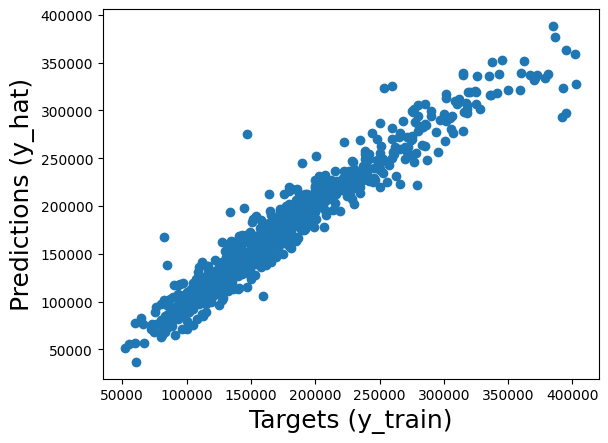

In [61]:

plt.scatter(y_train, y_hat)
# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

This indicates that the model's predictions are close to the actual values. A perfect model would have all points lying exactly on the diagonal.

Text(0.5, 1.0, 'Residuals PDF')

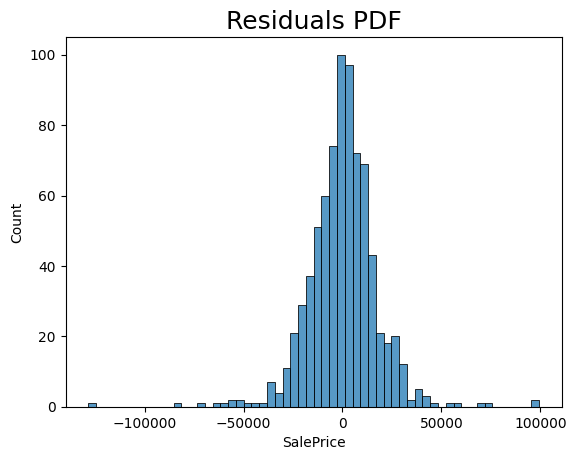

In [62]:
sns.histplot(y_train - y_hat)

# Include a title
plt.title("Residuals PDF", size=18)

The plot appears to be roughly bell-shaped, which is a good sign. This suggests that the residuals are normally distributed, which is an assumption of many statistical models.

##### R-squared

In [63]:
reg.score(x_train,y_train)

0.930524357845298

Approximately 93.05% of the variance in the dependent variable is explained by the selected features.

##### Bias

In [64]:
reg.intercept_

np.float64(176557.4447884417)

#####  weights

In [65]:

reg.coef_


array([ 11407.33362266,  25913.34676442,   7548.24319473,   6154.33358015,
         5968.77934628,  -6926.87193246,   4364.32542574, -10736.16739273,
         6428.70521103,   6697.35915224,   4798.92050657,   6166.23485679,
        10092.82199302,   4536.60259628,  -2801.98054331,  -8716.58056226,
         4839.64495618,   4864.39632134,   4535.98981718,   3938.98273718,
         3470.38704093,   2394.60615894,   2195.90956327,  -2611.02826001,
         2500.06799588,   2313.75687932,   1505.50246789,    115.74847356,
         2375.97416749,   1536.71975766,   1732.44894066,   1925.38591703,
        -5922.11068351,    956.71738246,   1328.07016872,  -2877.71099324,
         1444.49772646,   1749.46530254,  -1179.45446798,  -2284.05832914,
        -4064.65914435,   5026.67058574,  -1495.49717105,  -3076.44035241,
         1445.4714574 ,   1453.81811708,   1225.26445785,  -1693.28747999,
        -1224.172952  ,  -1707.60269599,  -1339.69676966,  -1400.16145869,
         1723.29863547,  

# TEST

##### scaling the test set to match the train scale

In [66]:
test_data_selected = test_data[corresponding_value]


# Fit the scaler on the training data and transform
test_data_scaled = scaler.fit_transform(test_data_selected)  

# Convert the scaled data back to a Pandas DataFrame
test_data_scaled = pd.DataFrame(test_data_scaled, columns=test_data_selected.columns, index=test_data_selected.index)

##### Make predictions on the Test_Data

In [67]:
predictions = model.predict(test_data_scaled)

In [68]:
list_predictions = predictions.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]
print(rounded_list_predictions)

[222286, 128897, 116236, 149989, 129619, 263207, 58072, 181372, 154574, 138853, 136699, 289634, 273141, 177107, 147957, 433228, 124519, 173443, 217456, 51983, 122672, 192109, 152888, 190429, 130114, 120572, 185504, 202132, 167886, 106564, 123477, 151080, 318379, 246274, 152910, 175694, 84467, 142302, 215261, 224767, 153728, 159460, 210078, 120829, 121519, 109609, 131014, 226250, 289450, 193334, 275051, 143569, 118570, 214084, 153357, 175257, 114318, 186137, 130000, 121510, 98341, 106231, 148610, 117398, 215080, 242377, 165662, 213978, 272644, 84716, 199001, 245384, 76706, 222093, 151001, 209569, 126104, 190420, 87180, 152202, 142491, 166577, 225007, 246071, 107753, 227335, 257640, 149369, 289787, 159616, 158377, 182964, 335545, 151516, 144757, 74317, 117107, 213690, 155210, 86140, 198426, 110428, 292739, 155406, 103450, 106083, 201577, 140996, 261525, 343854, 206055, 202692, 57363, 142703, 105520, 137659, 144949, 217672, 256851, 286403, 247940, 215687, 306615, 135486, 103272, 200396, 1